In [2]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree

from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [5]:
def preprocess_data(file_path='HRV.csv'):
    heart_rate_data = pd.read_csv(file_path)
    # Select features and labels
    X = heart_rate_data[['heart_rate', 'sdnn', 'rmssd']]
    y = heart_rate_data['condition']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test


In [17]:
X_train, X_test, y_train, y_test = preprocess_data()

clf = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)

In [18]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
values = clf.tree_.value

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=np.around(values[i], 3),
            )
        )

The binary tree structure has 9 nodes and has the following tree structure:

node=0 is a split node with value=[[0.54  0.278 0.182]]: go to node 1 if X[:, 0] <= 93.48403930664062 else to node 2.
	node=1 is a split node with value=[[0.75 0.25 0.  ]]: go to node 3 if X[:, 0] <= 66.60107421875 else to node 4.
	node=2 is a split node with value=[[0.    0.352 0.648]]: go to node 7 if X[:, 2] <= 80.04308319091797 else to node 8.
		node=3 is a leaf node with value=[[0.222 0.778 0.   ]].
		node=4 is a split node with value=[[0.818 0.182 0.   ]]: go to node 5 if X[:, 0] <= 70.14482498168945 else to node 6.
			node=5 is a leaf node with value=[[0.612 0.388 0.   ]].
			node=6 is a leaf node with value=[[0.855 0.145 0.   ]].
		node=7 is a leaf node with value=[[0.    0.296 0.704]].
		node=8 is a leaf node with value=[[0.    0.534 0.466]].


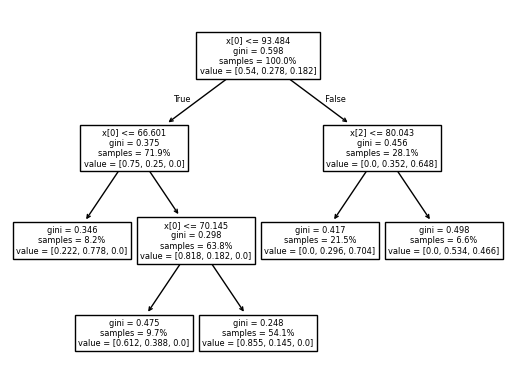

In [19]:
tree.plot_tree(clf, proportion=True)
plt.show()

In [15]:

# Obtain the decision path and leaf nodes for the samples in X_test
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

# Select a sample to interpret
sample_id = 11

# Get the feature and threshold used in each decision node
feature = clf.tree_.feature
threshold = clf.tree_.threshold

# Obtain the indices of the nodes that sample `sample_id` goes through
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print(f"Rules used to predict sample {sample_id}:\n")
for node_id in node_index:
    # Continue to the next node if it's a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # Determine if the value of the split feature is below or above the threshold
    # If X_test is a DataFrame, convert to a Numpy array to use indices
    sample_value = X_test.iloc[sample_id, feature[node_id]] if isinstance(X_test, pd.DataFrame) else X_test[sample_id, feature[node_id]]
    
    if sample_value <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        f"Decision node {node_id} : (X_test[{sample_id}, {feature[node_id]}] = {sample_value}) "
        f"{threshold_sign} {threshold[node_id]}"
    )

Rules used to predict sample 11:

Decision node 0 : (X_test[11, 0] = 97) <= 100.5
Decision node 1 : (X_test[11, 0] = 97) > 58.5


In [17]:
heart_rate_value = 46  # Replace this with the heart rate you want to predict
input_data = np.array([[heart_rate_value]])  # Shape it to be 2D: (n_samples, n_features)

predicted_class_index = clf.predict(input_data)

# Decode the predicted class back to original label using the label encoder
predicted_class_label = label_encoder.inverse_transform(predicted_class_index)

print(f"Predicted condition for heart rate {heart_rate_value}: {predicted_class_label[0]}")

Predicted condition for heart rate 46: Arrhythmia


C:\Users\cheta\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
